In [26]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### parallelization 
options = qt.Options(num_cpus=6)

In [27]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    "font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

In [28]:

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

# Model

## Jumping rates

In [29]:
def Trott_organize_jumps(col_times, col_which, Nboxes, args):
    # Initialize empty array
    dt = args["tau"]/(Nboxes-1)
    
    current = np.zeros(Nboxes)
    
    # Organize time instants into arrays
    for i, col_list in enumerate(col_which):
        for j, col in enumerate(col_list):
            current[i] += 1
        
    return np.array(current)/dt

In [30]:
def J_01_rate(t, args): 
    return np.sqrt(args["kappa"]) 

In [31]:
def DualSuperOperator_Lindbladian(t, args):
    """
        Code for checking if the left eigenmatrix is the actual one 
    """
    #####
    H0 = get_Hamiltonian(t, args)

    cops = get_cops(t, args)
    
    dO = 1.0j*( H0 * O - O * H0)
    
    for i, c in enumerate(cops):
        dO += (np.exp(-args["s_func"](t, args)*heat_current(t, i, args)) * c.dag() * O * c 
               -  0.5 * (c.dag() * c * O + O * c.dag() * c) )
    return dO 

In [32]:
def Tilted_lindbladian(t, args):

    """
        Evaluate the vectorize tilted Lindbladian at time $t$
    """
    
    #####
    
    H0 = get_Hamiltonian(t, args)
    
    J = get_Cops(t, args)   #### Change this in case of more jump operators 

    s = args["s_t"](t, args)
    
    Ide = qt.qeye(3)
    
    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()

    ########### Flattening the operators
    ####### Non-hermitian evolution 
    ## hot bath
    
    Flat_J = -(1.0/2.0)*(qt.tensor(Ide, J.dag()*J) + qt.tensor((J.dag()*J).trans(), Ide)).full()
    
    ####### Jumps 

    Flat_jump_J = (qt.tensor(J.conj(),J)).full()

    ####### Tilte 
    
    Flat_Jump = np.exp(-s)*Flat_jump_J
                  

    Lst = Flat_H0 + Flat_J + Flat_Jump 

    return Lst.astype(complex)




In [33]:
def Doob_system(t, args):
    """
        Evaluate the auxiliary doob Hamiltonian 
    """
    #### Tilted Lindbladian 
    Ls = Tilted_lindbladian(t, args)
    lambda0, l0 = Numeric_diagonalization(Ls, side="left")
    
    #### Non-hermitian term of the deterministic evolution
    
    Heff = get_Hamiltonian(t, args)
    c = get_Cops(t, args)

    Heff -= 0.5j * c.dag() * c
            
    #### Calculating the Doob

    l0sqr = qt.Qobj(l0).sqrtm()
    Heff = l0sqr * Heff * l0sqr.inv()

    Heff = 0.5*(Heff + Heff.dag())
    
    rotated_operator = l0sqr*c*l0sqr.inv()
    rotated_rate = np.exp(-args["s_t"](t, args)/2)
    
            
    return Heff, rotated_rate*rotated_operator

In [34]:
def get_Hamiltonian(t, args):

    Omega1 = args["Omega1_t"](t, args)
    Omega2 = args["Omega2_t"](t, args)

    ket0= qt.basis(3,2)
    ket1= qt.basis(3,1)
    ket2= qt.basis(3,0)

    Hamiltonian = (Omega1 * (ket0 * ket1.dag() + ket1 * ket0.dag())
                   + Omega2 * (ket0 * ket2.dag() + ket2 * ket0.dag()))

    return Hamiltonian

def get_Cops(t, args):

    kappa = args["kappa_t"](t, args)

    ket0= qt.basis(3,2)
    ket1= qt.basis(3,1)

    J = np.sqrt(kappa) * ket0 * ket1.dag()
    return J 

def get_Psi0(t, args):

    ket0= qt.basis(3,2)

    return ket0

In [35]:
def OneTrajectory(psi, tlist, args):
    """
        Computates one trajectory of the adiabatic evolution
        using the method of deviting the interval in $N$ subintervals, not at $dt$. 
    """
    jumps = []
    times = []

    dt = tlist[1]-tlist[0]
    for i, t in enumerate(tlist):

        Hamiltonian = get_Hamiltonian(t, args)
        c_ops = get_Cops(t, args)
        
        print("Time interval {} + {} \n".format(t, dt))
        aux_tlist = np.linspace((i+1)*dt, (i+2)*dt, 1000)
        Haux, Jaux = Doob_system(t, args)
        result = qt.mcsolve(Haux, psi, aux_tlist, Jaux, args=args, ntraj=1)

        jumps.append(result.col_which[0])
        times.append(result.col_times[0])

        psi = result.states[0][-1]
    return jumps, times

# Geting the SCGF

In [236]:
############# Get scaled cumulant generating function

def f(tlist, slist, args):
    """
        Evaluate a grid of the SCFG in (s(t), t)
    """
    grid = np.zeros((len(tlist), len(slist)))
    
    for i, t in enumerate(tlist):
        aux_cops = get_Cops(t, args)
        for j, s in enumerate(slist):
            args_copy = args.copy()
            args_copy["s_t"] = lambda t, args: s
            
            e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, args_copy), side="right")
            grid[i][j] = np.real(e_val)
            
    return grid.real  

############# Get activities for a trajectory

def get_activities(Slen, s0, sf, Tlen, args):
    """
        Evaluate a grid of the derivative of SCFG in (s(t), t)
    """
    # Compute the Legendre transform for each 

    grid = f(tlist=np.linspace(0, args["tau"], Tlen),
             slist=np.linspace(s0, sf, Slen),
             args=args)
    
    return -np.gradient(grid, np.linspace(s0, sf, Slen),  edge_order=2, axis=1)

############# Evaluating the SCGF in the path

def get_qs_path(activities, Tlen, Slen, s0, sf, args):
    """
        Get the value of the SCGF at s(t)
    """
    
    slist_aux = np.linspace(s0, sf, Slen)
    tlist_aux = np.linspace(0, args["tau"], Tlen)

    qs_values = []
    for i, t in enumerate(tlist_aux):
        qs_values.append(np.interp(args["s_t"](t, args),  slist_aux, activities[i] ))
    return qs_values

# Parameters

In [281]:
####### Parameters 

####### Time window 

tau = int(5e6)
Nsteps = 100
tlist_traj = np.linspace(0, tau, Nsteps)

#######

s = 1

#####
Omega1 = 1.0

Omega2 = Omega1/10
kappa = 4 * Omega1

def Omega1_t(t, args):
    return args["Omega1"]*(1 - 0.5*np.sin(2*np.pi * t/args["tau"]))

def Omega2_t(t, args):
    return args["Omega2"]

def kappa_t(t, args):
    return args["kappa"]

def s_t(t, args):
    return -args["s"]*np.sin(2*np.pi * t/args["tau"])


args_st = {"Omega1":Omega1,
        "Omega2":Omega2,
        "kappa":kappa,
        "Omega1_t":Omega1_t,
        "Omega2_t":Omega2_t,
        "kappa_t":kappa_t,
        "tau":tau,
        "s":s,
        "s_t":s_t}


args_s0 = {"Omega1":Omega1,
        "Omega2":Omega2,
        "kappa":kappa,
        "Omega1_t":Omega1_t,
        "Omega2_t":Omega2_t,
        "kappa_t":kappa_t,
        "tau":tau,
        "s":s,
        "s_t":lambda t, args: 0}
#### Parameters for predicting the s-activits'

Slen=1000
s0=-1
sf=1
Tlen=50


In [282]:
psi0 = get_Psi0(t=0, args=args_s0)

In [283]:
jumps_s0, times_s0 =  OneTrajectory(psi0, tlist_traj, args_s0)

Time interval 0.0 + 50505.0505050505 

Total run time:   3.73s
Time interval 50505.0505050505 + 50505.0505050505 

Total run time:   3.54s
Time interval 101010.101010101 + 50505.0505050505 

Total run time:   3.28s
Time interval 151515.1515151515 + 50505.0505050505 

Total run time:   3.27s
Time interval 202020.202020202 + 50505.0505050505 

Total run time:   3.36s
Time interval 252525.25252525252 + 50505.0505050505 

Total run time:   3.03s
Time interval 303030.303030303 + 50505.0505050505 

Total run time:   2.90s
Time interval 353535.3535353535 + 50505.0505050505 

Total run time:   2.87s
Time interval 404040.404040404 + 50505.0505050505 

Total run time:   2.69s
Time interval 454545.45454545453 + 50505.0505050505 

Total run time:   2.68s
Time interval 505050.50505050505 + 50505.0505050505 

Total run time:   2.63s
Time interval 555555.5555555555 + 50505.0505050505 

Total run time:   2.71s
Time interval 606060.606060606 + 50505.0505050505 

Total run time:   2.43s
Time interval 65

In [284]:
act_s0 = Trott_organize_jumps(times_s0, jumps_s0, Nsteps, args_s0)

(0.0, 1.0)

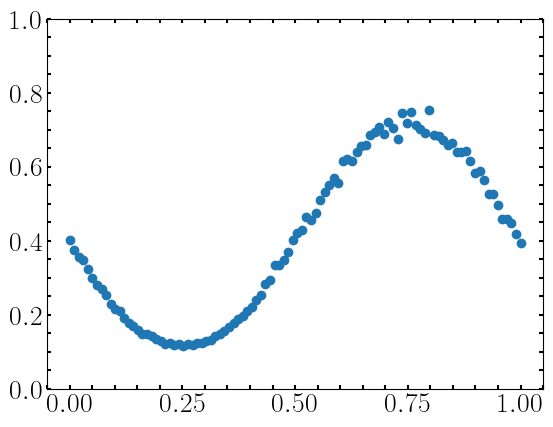

In [285]:
plt.scatter(tlist_traj/tau, act_s0)
plt.ylim((0,1))

# Time-dependent s

In [286]:
jumps_st, times_st =  OneTrajectory(psi0, tlist_traj, args_st)

Time interval 0.0 + 50505.0505050505 

Total run time:   3.64s
Time interval 50505.0505050505 + 50505.0505050505 

Total run time:   4.71s
Time interval 101010.101010101 + 50505.0505050505 

Total run time:   5.04s
Time interval 151515.1515151515 + 50505.0505050505 

Total run time:   5.37s
Time interval 202020.202020202 + 50505.0505050505 

Total run time:   5.22s
Time interval 252525.25252525252 + 50505.0505050505 

Total run time:   5.21s
Time interval 303030.303030303 + 50505.0505050505 

Total run time:   5.20s
Time interval 353535.3535353535 + 50505.0505050505 

Total run time:   5.15s
Time interval 404040.404040404 + 50505.0505050505 

Total run time:   5.07s
Time interval 454545.45454545453 + 50505.0505050505 

Total run time:   5.04s
Time interval 505050.50505050505 + 50505.0505050505 

Total run time:   5.13s
Time interval 555555.5555555555 + 50505.0505050505 

Total run time:   5.11s
Time interval 606060.606060606 + 50505.0505050505 

Total run time:   5.09s
Time interval 65

In [287]:
act_st = Trott_organize_jumps(times_st, jumps_st, Nsteps, args_st)

(0.0, 2.0)

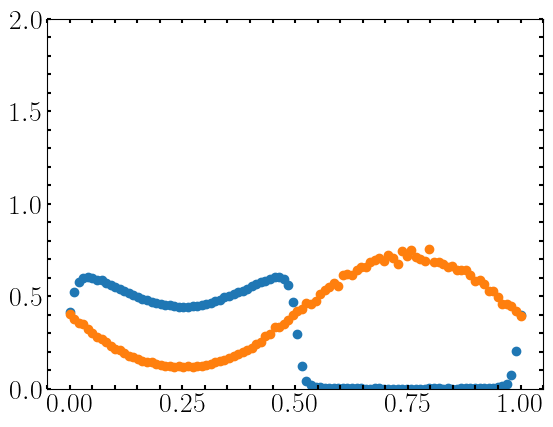

In [288]:
plt.scatter(tlist_traj/tau, act_st)
plt.scatter(tlist_traj/tau, act_s0)

plt.ylim((0, 2))

# Theory prediction

In [289]:
activities = get_activities(Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

In [290]:
act_theory_st = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

In [291]:
act_theory_s0 = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)

# Plotting 

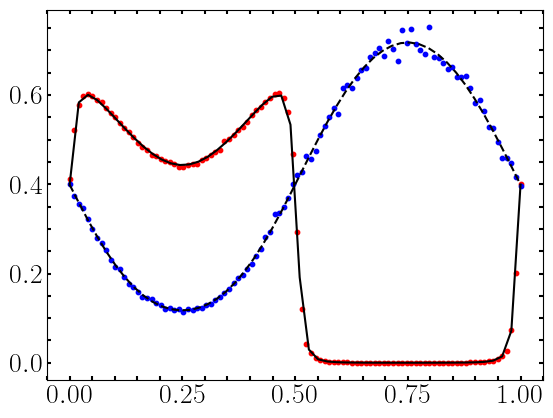

In [292]:
plt.scatter(tlist_traj/tau, act_st, color="red", s=10)
plt.scatter(tlist_traj/tau, act_s0, color="blue", s=10)

plt.plot(np.linspace(0, 1, len(act_theory_st)), act_theory_st, color="black", linestyle="-")
plt.plot(np.linspace(0, 1, len(act_theory_s0)), act_theory_s0, color="black", linestyle="--")


# Saving

In [295]:
data_s0 = args_s0.copy()
data_s0.update({"jumps":jumps_s0})
data_s0.update({"times":times_s0})
data_s0.update({"act":act_s0})
data_s0.update({"SCFG_prediction":act_theory_s0})
data_s0.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_s0.update({"tlist":np.linspace(0, 1, Tlen)})

del data_s0["s_t"]
del data_s0["Omega1_t"]
del data_s0["Omega2_t"]
del data_s0["kappa_t"]


with open('Data_blinking_s0.pickle', 'wb') as handle:
    pickle.dump(data_s0, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [296]:
data_st = args_st.copy()
data_st.update({"jumps":jumps_st})
data_st.update({"times":times_st})
data_st.update({"act":act_st})
data_st.update({"SCFG_prediction":act_theory_st})
data_st.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_st.update({"tlist":np.linspace(0, 1, Tlen)})

del data_st["s_t"]
del data_st["Omega1_t"]
del data_st["Omega2_t"]
del data_st["kappa_t"]

with open('Data_blinking_st.pickle', 'wb') as handle:
    pickle.dump(data_st, handle, protocol=pickle.HIGHEST_PROTOCOL)
